# Ejercicio N°3.1
Supongamos que tenemos un dataset mezcla de dos grupos aleatorios bidimensionales (cada uno con 100 datos, su centroide y covariancia).

Encontrar un clasificador por K-NN y evaluar exactitud, precisión, f-measure. Tomar inicialmente un dataset de entrenamiento de N=100 (50+50), k=10, y validar con el resto del dataset. Hacer algunos experimentos con otros N y k, y
también cambiando centroide y covariancia de las clases.

Optativo: Cambia mucho si el dataset tiene más dimensiones?

In [1]:
#@title 0.- Import de lib a usar y funciones adicionales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import time

sns.set_theme(style="darkgrid")

In [2]:
# Generacion dataset sintetico 2D
# ----------------------------------------------------------------------------
# N0: # de target 0; N1: # de target 1 
def Generacion_data(N0=150, N1=150,figs=1):
  mu0 = [0, 0]; ro0 = 0;  cov0 = [[.1, ro0],[ro0,1]]
  mu1 = [0, 0]; ro1 = 0;  cov1 = [[1, ro1],[ro1,.1]]

  Grupo0 = np.random.multivariate_normal(mu0,cov0,int(N0))
  Grupo1 = np.random.multivariate_normal(mu1,cov1,int(N1))

  df0 = pd.DataFrame({'X1':Grupo0[:,0],'X2':Grupo0[:,1],'target':np.zeros(int(N0),dtype=int)})
  df1 = pd.DataFrame({'X1':Grupo1[:,0],'X2':Grupo1[:,1],'target':np.ones(int(N1),dtype=int)})
  df = pd.concat([df0,df1],ignore_index=True)

  if figs:
    _,ax = plt.subplots()
    sns.scatterplot(data=df,x='X1',y='X2',hue='target',ax=ax)
    if np.max([N0,N1]) < 1.6*np.min([N0,N1]):
      ax.set_title('Data balanceado '+'N0 = '+str(N0)+', N1 = '+str(N1))
    else:
      ax.set_title('Data desbalanceado '+'N0 = '+str(N0)+', N1 = '+str(N1))

  return(df)

# Metricas para la evaluación del desempeño del modelo
# ----------------------------------------------------------------------------
def metricas(y,y_pred,ponderacion='weighted'):
  m_balanced_accuracy = metrics.balanced_accuracy_score(y,y_pred)
  m_f1 = metrics.f1_score(y,y_pred, average=ponderacion)
  m_precision = metrics.precision_score(y,y_pred, average=ponderacion,zero_division=1)
  m_recall = metrics.recall_score(y,y_pred, average=ponderacion,zero_division=0)
  return m_balanced_accuracy,m_f1,m_precision,m_recall

# Clasificadores KNN
# ----------------------------------------------------------------------------
def metricas_clasificadores_knn(dataset,ax,ponderacion = 'weighted'):
# dataset: es una lista [X_train, y_train, X_test,y_test] 
# de len 2 (datos de entrenamiento) o len 4 (entrenamiento y validación)    
# Se generan diferentes modelos de clasificadores (variando la cantidad de vecinos),
# y se guardan metricas para cada caso.

  len(dataset)
  if len(dataset)==2: 
      X_train = dataset[0]; y_train = dataset[1]
      X_test  = dataset[0]; y_test  = dataset[1]
      #print('len2 \n')
  elif len(dataset)==4:
      X_train = dataset[0]; y_train = dataset[1]
      X_test  = dataset[2]; y_test  = dataset[3]
      #print('len4 \n')
  else:
      print('Error en la longitud del dataset')
    
  # Seteo del clasificador
  kmax = 30   # maxima cantidad de k-vecinos a usar
  # Datos para el entrenamiento
  #X = df.drop('target',axis=1)
  #y = df['target']
  X_train = np.array(X_train);
  y_train = np.array(y_train)#.reshape(-1,1)

  kvecinos = np.zeros(kmax)
  m_balanced_accuracy = np.zeros(kmax)
  m_f1 = np.zeros(kmax)
  m_precision = np.zeros(kmax)
  m_recall = np.zeros(kmax)
  knn_score = np.zeros(kmax)

  # Ajuste de varios clasificadores para evaluar metricas
  for k in range(kmax):
    kvecinos[k] = k+1
    Myknn = KNeighborsClassifier(n_neighbors=k+1)       # se instancia el modelo
    Myknn.fit(X_train,y_train)                          # ajuste del modelo  
    y_pred = Myknn.predict(X_test)                      # predicciones sobre el test
    knn_score[k]=Myknn.score(X_test,y_test)
    m_balanced_accuracy[k],m_f1[k],m_precision[k],m_recall[k] = metricas(y_test,y_pred,ponderacion)

  # Preparación de metricas para ploteo
    df_score = pd.DataFrame({'k-vecinos':kvecinos,'balanced_accuracy': m_balanced_accuracy,
                            'f1 score':m_f1,'precision':m_precision,'recall':m_recall,'knn-score':knn_score})

  #df_score = pd.DataFrame({'k-vecinos':kvecinos,'f1 score':m_f1,'precision':m_precision,'recall':m_recall})#,'knn-score':knn_score})

  #_,ax = plt.subplots()
  sns.lineplot(data=pd.melt(df_score, 'k-vecinos',var_name='Medidas'),x='k-vecinos', y='value', hue='Medidas',ax=ax )
# fin def --------------------------------------------------------------------


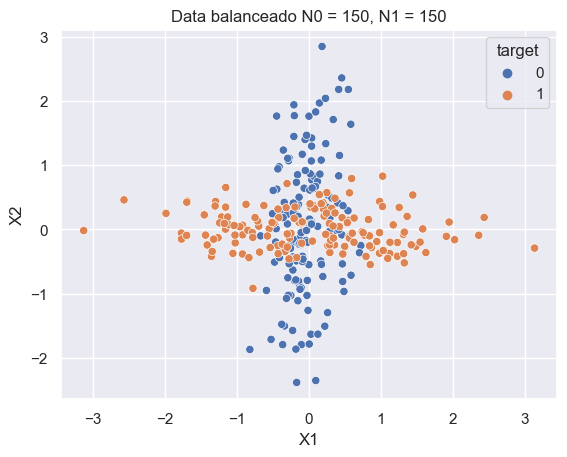

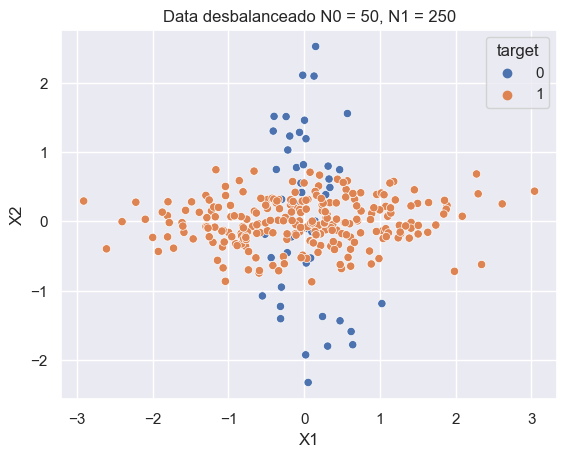

In [3]:
#@title 1.- Generacion dataset sintetico 2D
# N0: # de target 0; N1: # de target 1 
df_sim   = Generacion_data(150,150); #plt.title('Data balanceado')
df_nosim = Generacion_data(50,250);  #plt.title('Data desbalanceado')

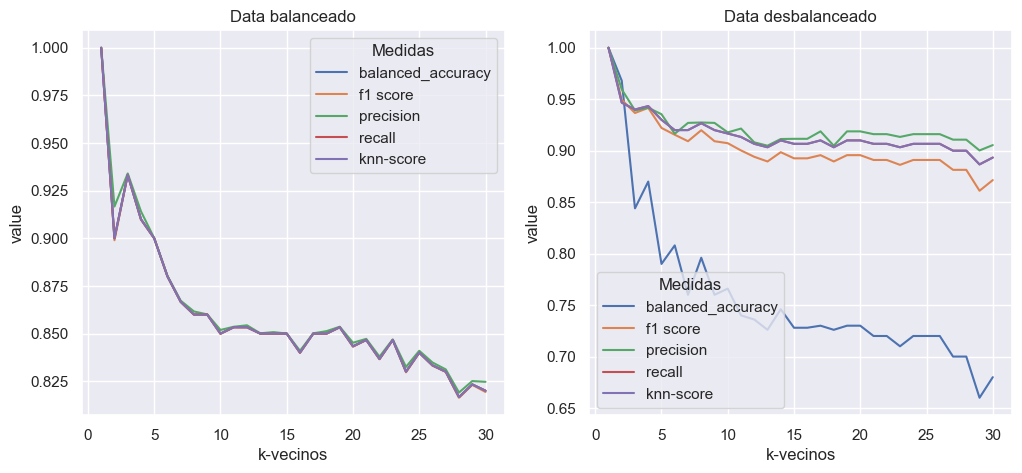

In [4]:
#@title 2.- Clasificador KNN
fig,ax = plt.subplots(1,2,figsize=(12,5))
X = df_sim.drop('target',axis=1); X = np.array(X);
y = df_sim['target']; y = np.array(y)
metricas_clasificadores_knn([X,y],  ax[0]); ax[0].set_title('Data balanceado');

X = df_nosim.drop('target',axis=1); X = np.array(X);
y = df_nosim['target']; y = np.array(y)
metricas_clasificadores_knn([X,y],ax[1]); ax[1].set_title('Data desbalanceado');


## Conclusion
.- En un dataset balanceado puede notarse que las metricas son similares.

.- En un dataset no balanceado, solamente la _balanced_accuracy_resultada afectada.

# Ejercicio N°3.2
(optativo): Hacer alguna experiencia con el dataset anterior utilizando validáción
cruzada y (o) grid search.

Mejor elección de cantidad de vecinos es: {'n_neighbors': 7}
Score alcanzado: 89.35%


Text(0.5, 1.0, 'CV recall_score')

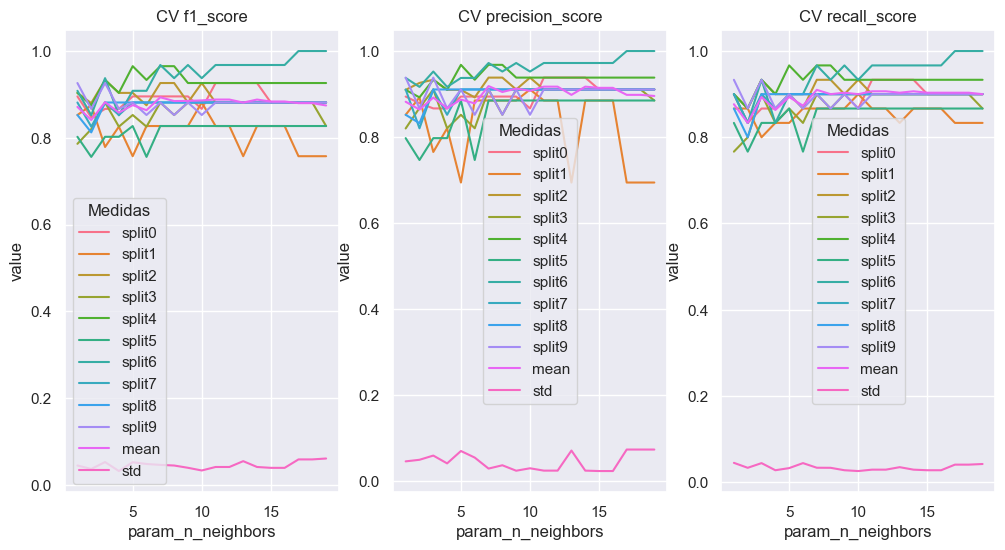

In [5]:
# Datos para el entrenamiento
# ----------------------------------------------------------------------------
import warnings 
warnings.filterwarnings('ignore') 

df=df_nosim
x_train = df.drop(['target'],axis=1)
y_train = df['target']

knn = KNeighborsClassifier()
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

# Seteo de la crossvalidation
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    knn,
                    param_grid,
                    cv=10,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit= 'f1_weighted',
                    return_train_score=False,
                    verbose=0)

# Ajuste
grid_search=grid.fit(x_train, y_train)

# Resultados
# ----------------------------------------------------------------------------
print('Mejor elección de cantidad de vecinos es:',grid_search.best_params_)
metrica = grid_search.best_score_ *100
print("Score alcanzado: {:.2f}%".format(metrica) )

# Cv para distintas metricas: f1_weighted, precision_we ighted, recall_weighted
grid_cv = pd.DataFrame(grid.cv_results_)
grid_cv = grid_cv.drop(['params']+[col for col in grid_cv.columns if 'rank' in col],axis=1)
grid_cv_long = grid_cv.melt('param_n_neighbors',var_name='Medidas')

grid_cv_f1 = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('f1')]
grid_cv_f1 = grid_cv_f1.replace('_test_f1_weighted','',regex=True)
#-------------------------------------------------------------------------------
grid_cv_precision = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('precision')]
grid_cv_precision = grid_cv_precision.replace('_test_precision_weighted','',regex=True)
#-------------------------------------------------------------------------------
grid_cv_recall = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('recall')]
grid_cv_recall = grid_cv_recall.replace('_test_recall_weighted','',regex=True)

_,ax = plt.subplots(1,3,figsize=(12,6))
ax=ax;
sns.lineplot(grid_cv_f1,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[0])
ax[0].set_title('CV f1_score')

sns.lineplot(grid_cv_precision,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[1])
ax[1].set_title('CV precision_score')

sns.lineplot(grid_cv_recall,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[2])
ax[2].set_title('CV recall_score')


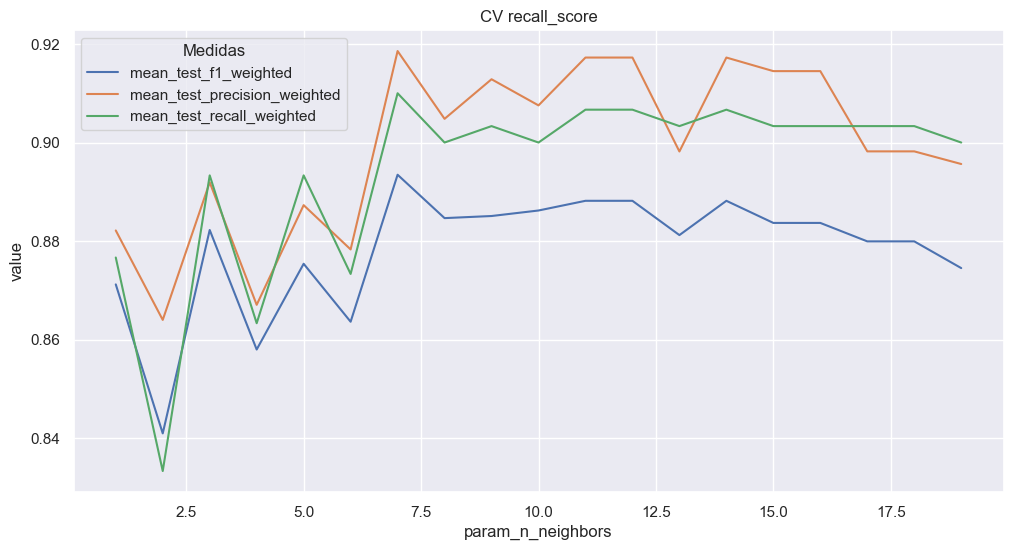

In [6]:
grid_cv_means = pd.concat([grid_cv.filter(like='neighbors'),
                            grid_cv.filter(like='mean_test')],axis=1)
grid_cv_means_long = grid_cv_means.melt('param_n_neighbors',var_name='Medidas')

_,ax = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(grid_cv_means_long,x='param_n_neighbors', y='value', hue='Medidas',ax=ax)
ax.set_title('CV recall_score');


En el notebook https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb
hay un dataset con 2000+ canciones de Spotify de una usuaria, donde algunas fueron
marcadas como gustadas y otras no. Cada canción tiene a su vez 16 atributos (nombre,
artista, duración, bailable, etc.). Desarrollar un clasificador que prediga si una canción dada va a ser
gustada o no. Aclarar y justificar los pasos, analizar y explicar los resultados.


# Ejercicio N°3.3
En el notebook https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb
hay un dataset con 2000+ canciones de Spotify de una usuaria, donde algunas fueron marcadas como gustadas y otras no. Cada canción tiene a su vez 16 atributos (nombre, artista, duración, bailable, etc.). Desarrollar un clasificador que prediga si una canción dada va a ser gustada o no. Aclarar y justificar los pasos, analizar y explicar los resultados.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


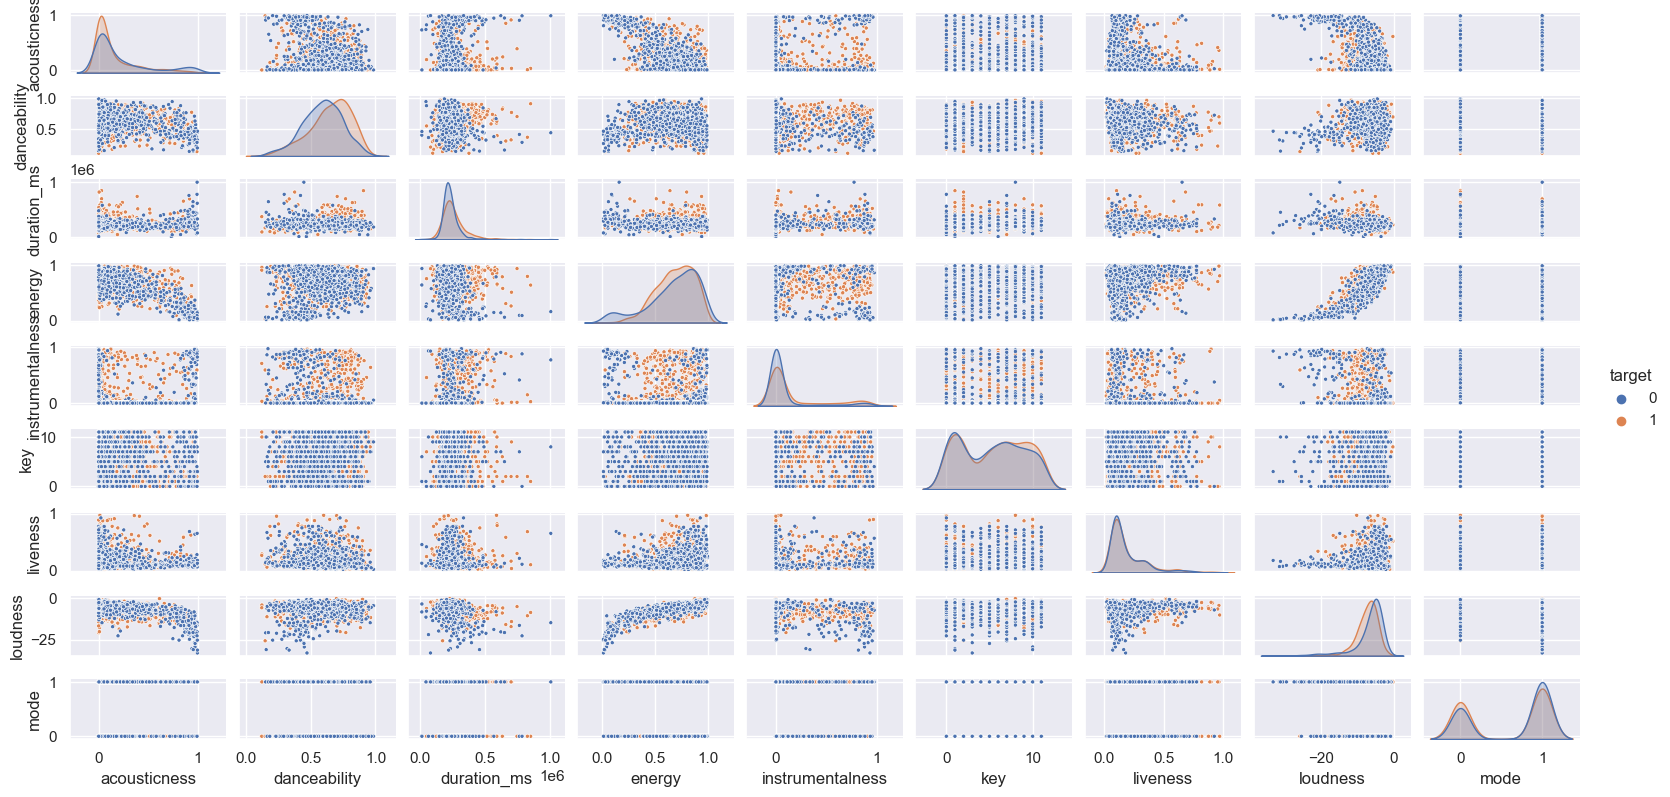

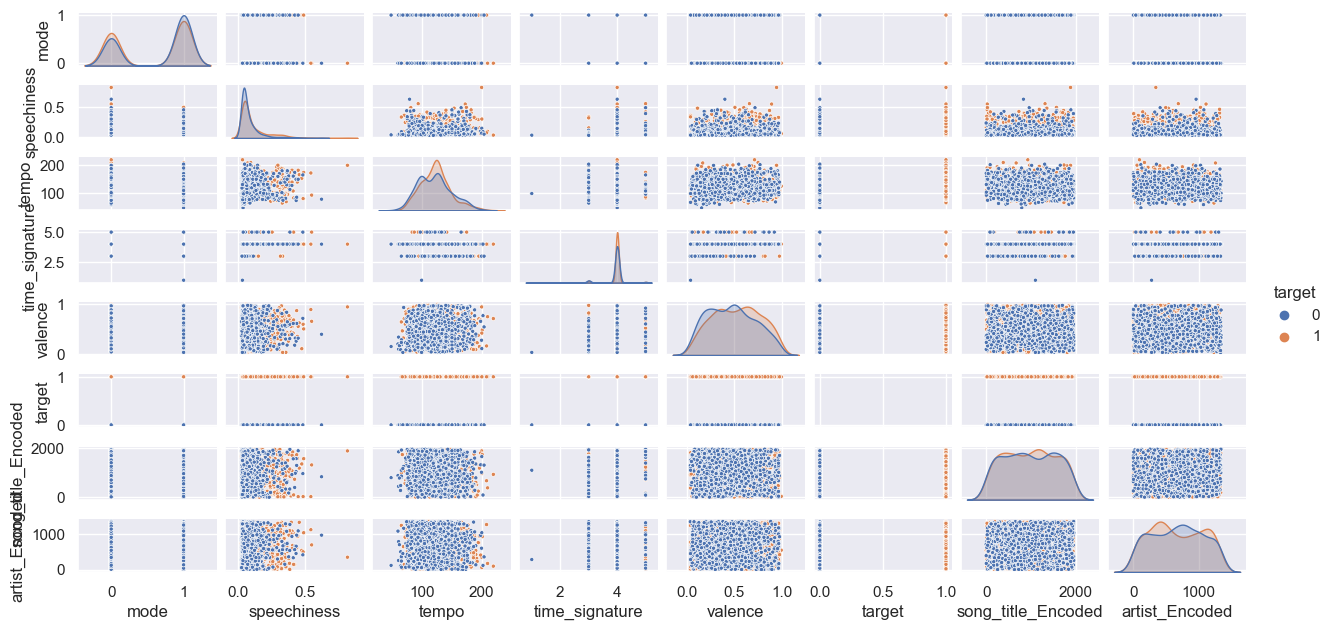

In [7]:
# Seteo de variables
# -----------------------------------------------------------------------------
url_file = 'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv'
attributes_spotify = pd.read_csv(url_file)

# 0. Carga de datos 
# -----------------------------------------------------------------------------
# 1. Exploración inicial
# info(), describe(), head(), y tail()
df=attributes_spotify
print(df.info())
dfC1 = df.dropna();

# -----------------------------------------------------------------------------
# 2. Visualizacion de datos cols respecto al tiempo y
label_encoder = LabelEncoder()
df.drop('Unnamed: 0',axis=1,inplace=True)
df['song_title_Encoded'] = label_encoder.fit_transform(df['song_title'])
df['artist_Encoded'] = label_encoder.fit_transform(df['artist'])
df.drop(['song_title','artist'],axis=1,inplace=True)

sns.pairplot(df,vars=df.columns[0:9],markers='.',diag_kind='kde',hue='target',height=.9,aspect=2)
sns.pairplot(df,vars=df.columns[[8,9,10,11,12,13,14,15]],markers='.',diag_kind='kde',hue='target',height=.8,aspect=2)



## Conclusión:
No se visualiza a priori un poder predictivo en los atributos 'loudness', 'mode', 'tempo', 'time_signature', 'valence', 'song_title_Encoded', 'artist_Encoded'.


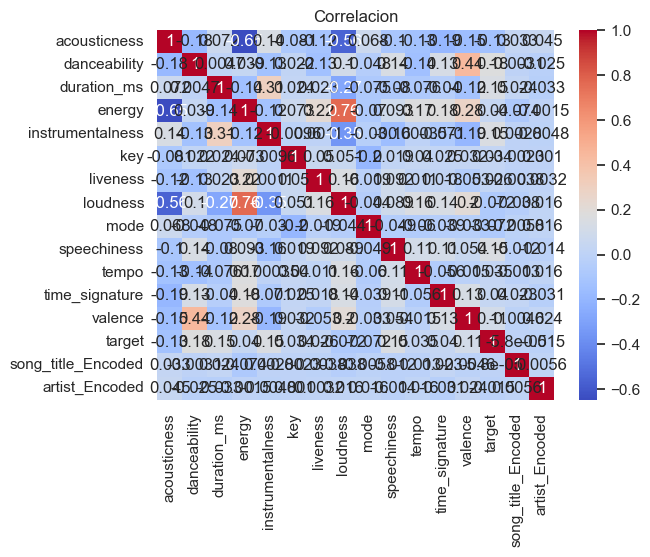

In [8]:
# 3. Analisis de correlación
namecols = df.columns
corr_matrix = df.corr()
#print(corr_matrix)

fig,ax=plt.subplots();
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',ax=ax)#'RdPu')
ax.set_title('Correlacion');

Son 1411 datos para entrenamiento y 606 datos para prueba


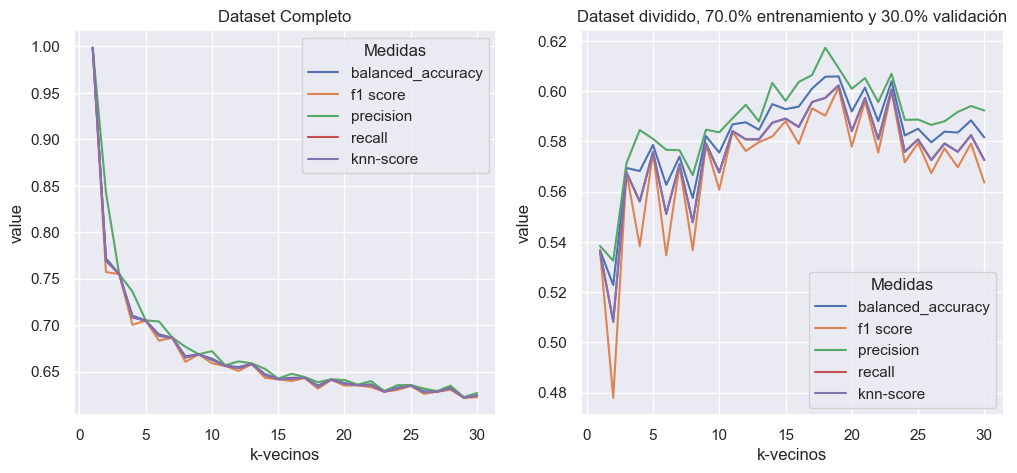

In [9]:
#%% # Ajuste knn con dataframe->array
# Preparacion de los datos
# -----------------------------------------------------------------------------
prop_test_size = 0.3
X = df.drop('target',axis=1)
y = df['target']
X = np.array(X);
y = np.array(y)#.reshape(-1,1)

# Entrenamiento y validación con el data completo
fig,ax = plt.subplots(1,2,figsize=(12,5))
dataset =[X,y]
metricas_clasificadores_knn(dataset,ax[0]); ax[0].set_title('Dataset Completo');

# Entrenamiento y validación divididos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prop_test_size)
print('Son {} datos para entrenamiento y {} datos para prueba'.
      format(X_train.shape[0], X_test.shape[0]))
dataset =  [X_train, y_train, X_test,y_test]
metricas_clasificadores_knn(dataset,ax[1]);
ax[1].set_title('Dataset dividido, {}% entrenamiento y {}% validación'.
                format(100*(1-prop_test_size),100*prop_test_size)); 